# Monet Style Painting Generational Adversatrial Network with CycleGAN
### Problem Overview:


### Dataset:
monet_jpg - 300 Monet paintings sized 256x256 in JPEG format
monet_tfrec - 300 Monet paintings sized 256x256 in TFRecord format
photo_jpg - 7028 photos sized 256x256 in JPEG format
photo_tfrec - 7028 photos sized 256x256 in TFRecord format

### Dependencies

In [1]:
!pip install optuna
!pip install tensorflow-hub==0.16.1 --no-deps

In [2]:
# TensorFlow and Keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# TensorFlow Addons for Instance Normalization (CycleGAN uses it instead of BatchNorm)
import tensorflow_addons as tfa

# Data Handling and Visualization
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time 
# Image Processing
import cv2
import PIL
from PIL import Image
import glob
import os
import shutil
import gc


# Suppress Warnings for Cleaner Output
import warnings
warnings.filterwarnings("ignore")


2025-03-02 04:17:05.373044: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-03-02 04:17:05.402227: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/usr/local/python/3.9.21/lib/python3.9/site-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow 

In [3]:
monet_jpg_path = '/workspace/data/monet_jpg'
monet_tfrec_path = '/workspace/data/monet_tfrec'
photo_jpg_path = '/workspace/data/photo_jpg'
photo_tfrec_path = '/workspace/data/photo_tfrec'


GPU Setup

In [4]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '0' # set log level to show all logs

print("TensorFlow version:", tf.__version__)
print("Built with CUDA:", tf.test.is_built_with_cuda())
print("CUDA available:", tf.test.is_built_with_gpu_support())
print(tf.config.list_physical_devices('GPU'))
# list all GPUs
gpus = tf.config.list_physical_devices('GPU')

# check compute capability if GPU available
if gpus:
    for gpu in gpus:
        details = tf.config.experimental.get_device_details(gpu)
        print(f"Device: {gpu.name}")
        print(f"Compute Capability: {details.get('compute_capability')}")
else:
    print("No GPU found.")

TensorFlow version: 2.13.0
Built with CUDA: True
CUDA available: True
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Device: /physical_device:GPU:0
Compute Capability: (8, 6)


2025-03-02 04:17:07.270134: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-03-02 04:17:07.274710: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-03-02 04:17:07.275036: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-03-02 04:17:07.275775: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.


In [5]:
# config GPU memory growth
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

# Exploratory Data Analysis (EDA) and Preprocessing
Here, I explore the data looking for any patterns that could give me clues on how to preprocess the images, clean the data, and setup my model architecture. I also preprocess my images.

In [6]:
# List all JPG images in the directories
monet_images = glob.glob(os.path.join(monet_jpg_path, "*.jpg"))
photo_images = glob.glob(os.path.join(photo_jpg_path, "*.jpg"))

# Print correct count
print(f"Found {len(monet_images)} Monet images and {len(photo_images)} photo images.")


Found 300 Monet images and 7038 photo images.


In [7]:
monet_tfrec_files = glob.glob(os.path.join(monet_tfrec_path, "*.tfrec"))
photo_tfrec_files = glob.glob(os.path.join(photo_tfrec_path, "*.tfrec"))

print(f"Found {len(monet_tfrec_files)} Monet TFRecord files and {len(photo_tfrec_files)} Photo TFRecord files.")


Found 5 Monet TFRecord files and 20 Photo TFRecord files.


In [8]:
import tensorflow as tf

def parse_tfrecord(example):
    feature_description = {
        "image": tf.io.FixedLenFeature([], tf.string),  # Image stored as bytes
        "image_name": tf.io.FixedLenFeature([], tf.string),  # Image filename
    }
    parsed_example = tf.io.parse_single_example(example, feature_description)
    
    # Decode the image from raw bytes
    image = tf.image.decode_jpeg(parsed_example["image"], channels=3)
    image = tf.image.resize(image, [256, 256])  # Resize to 256x256
    image = (tf.cast(image, tf.float32) / 127.5) - 1  # Normalize to [-1, 1]
    
    return image, parsed_example["image_name"]

# Load dataset and apply parsing
monet_tfrec_dataset = tf.data.TFRecordDataset(monet_tfrec_files).map(parse_tfrecord)
photo_tfrec_dataset = tf.data.TFRecordDataset(photo_tfrec_files).map(parse_tfrecord)
monet_tfrec_count = sum(1 for _ in monet_tfrec_dataset)
photo_tfrec_count = sum(1 for _ in photo_tfrec_dataset)

print(f"Monet TFRecord Dataset Size: {monet_tfrec_count}")
print(f"Photo TFRecord Dataset Size: {photo_tfrec_count}")


2025-03-02 04:17:07.329454: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-03-02 04:17:07.329804: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-03-02 04:17:07.330030: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-03-02 04:17:07.419848: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-03-02 04:17:07.420146: I tensorflow/compile

Monet TFRecord Dataset Size: 300
Photo TFRecord Dataset Size: 7038


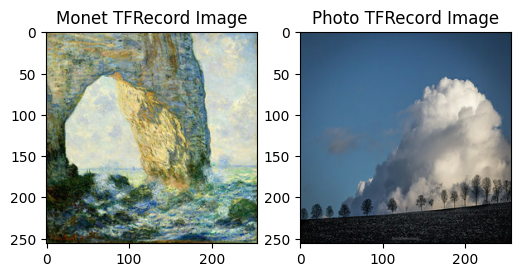

In [9]:
import matplotlib.pyplot as plt

# Get sample images from TFRecord dataset
monet_sample = next(iter(monet_tfrec_dataset))[0].numpy()
photo_sample = next(iter(photo_tfrec_dataset))[0].numpy()

# Convert from [-1,1] to [0,1] for visualization
monet_sample = (monet_sample + 1) / 2
photo_sample = (photo_sample + 1) / 2

# Plot the images
plt.figure(figsize=(6, 3))

plt.subplot(1, 2, 1)
plt.title("Monet TFRecord Image")
plt.imshow(monet_sample)

plt.subplot(1, 2, 2)
plt.title("Photo TFRecord Image")
plt.imshow(photo_sample)

plt.show()


In [10]:
# Get image shapes from the datasets
monet_shapes = [img.shape for img, _ in monet_tfrec_dataset.take(10)]
photo_shapes = [img.shape for img, _ in photo_tfrec_dataset.take(10)]

print("Monet Image Shapes:", set(monet_shapes))
print("Photo Image Shapes:", set(photo_shapes))


Monet Image Shapes: {TensorShape([256, 256, 3])}
Photo Image Shapes: {TensorShape([256, 256, 3])}


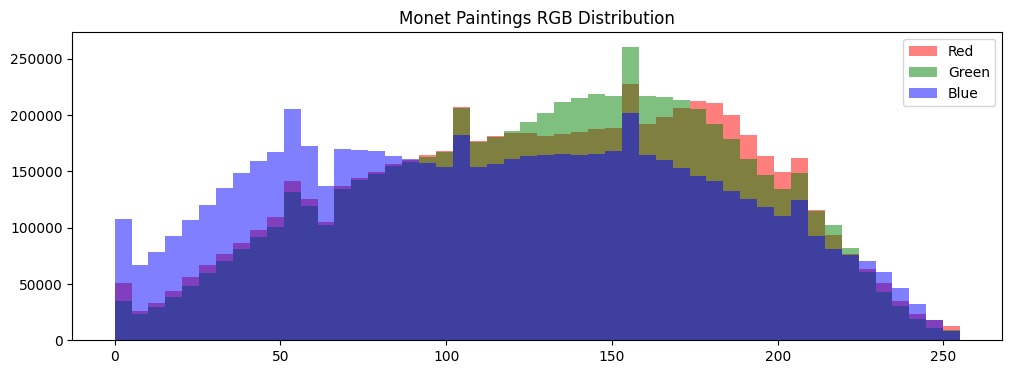

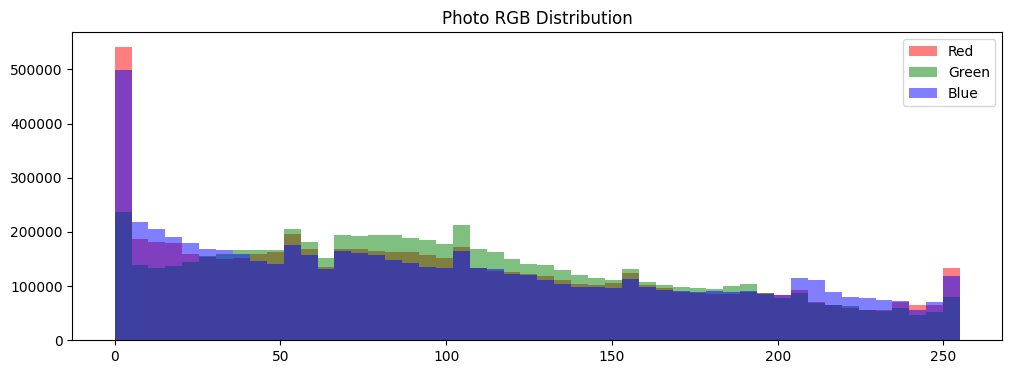

In [11]:
import numpy as np

def plot_rgb_histogram(dataset, title, num_samples=100):
    r_vals, g_vals, b_vals = [], [], []

    for img, _ in dataset.take(num_samples):
        img = ((img.numpy() + 1) * 127.5).astype(np.uint8)  # Convert from [-1,1] to [0,255]
        r_vals.append(img[:, :, 0].flatten())
        g_vals.append(img[:, :, 1].flatten())
        b_vals.append(img[:, :, 2].flatten())

    r_vals = np.concatenate(r_vals)
    g_vals = np.concatenate(g_vals)
    b_vals = np.concatenate(b_vals)

    plt.figure(figsize=(12, 4))
    plt.hist(r_vals, bins=50, color="red", alpha=0.5, label="Red")
    plt.hist(g_vals, bins=50, color="green", alpha=0.5, label="Green")
    plt.hist(b_vals, bins=50, color="blue", alpha=0.5, label="Blue")
    plt.legend()
    plt.title(title)
    plt.show()

# Plot color histograms for both datasets
plot_rgb_histogram(monet_tfrec_dataset, "Monet Paintings RGB Distribution")
plot_rgb_histogram(photo_tfrec_dataset, "Photo RGB Distribution")


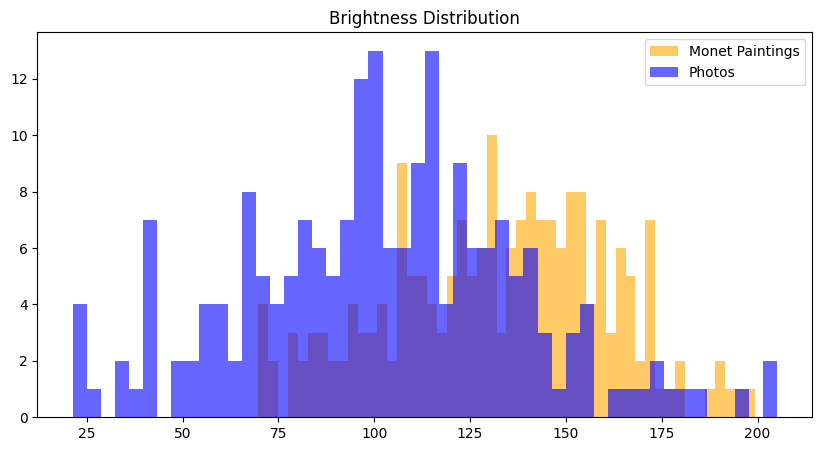

In [12]:
def compute_brightness(image):
    image = ((image + 1) * 127.5).numpy().astype(np.uint8)  # Convert back to [0,255]
    return np.mean(cv2.cvtColor(image, cv2.COLOR_RGB2GRAY))  # Convert to grayscale & compute mean

monet_brightness = [compute_brightness(img) for img, _ in monet_tfrec_dataset.take(200)]
photo_brightness = [compute_brightness(img) for img, _ in photo_tfrec_dataset.take(200)]

plt.figure(figsize=(10, 5))
plt.hist(monet_brightness, bins=50, alpha=0.6, label="Monet Paintings", color="orange")
plt.hist(photo_brightness, bins=50, alpha=0.6, label="Photos", color="blue")
plt.legend()
plt.title("Brightness Distribution")
plt.show()


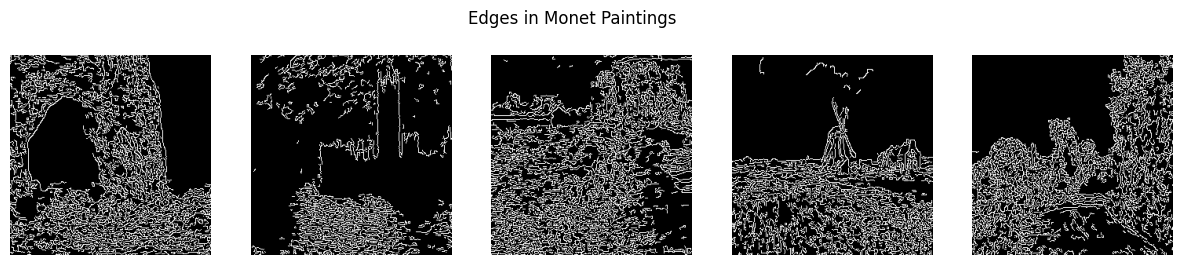

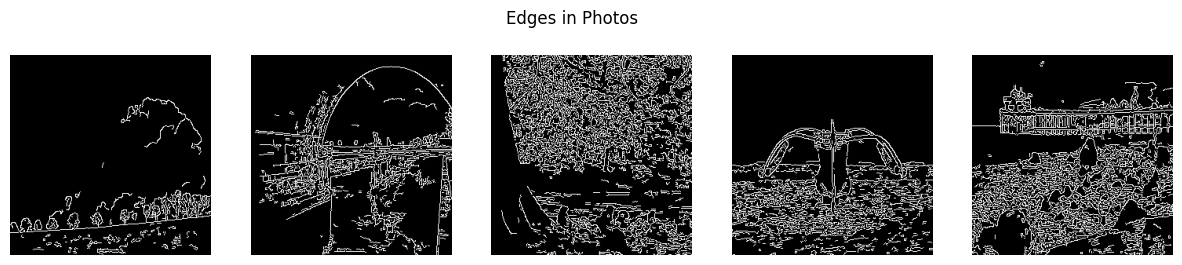

In [13]:
import cv2

def plot_edges(dataset, title):
    fig, axes = plt.subplots(1, 5, figsize=(15, 3))

    for i, (img, _) in enumerate(dataset.take(5)):
        img = ((img.numpy() + 1) * 127.5).astype(np.uint8)  # Convert back to [0,255]
        edges = cv2.Canny(cv2.cvtColor(img, cv2.COLOR_RGB2GRAY), 100, 200)  # Apply Canny edge detection
        axes[i].imshow(edges, cmap="gray")
        axes[i].axis("off")

    fig.suptitle(title)
    plt.show()

plot_edges(monet_tfrec_dataset, "Edges in Monet Paintings")
plot_edges(photo_tfrec_dataset, "Edges in Photos")


### EDA Insights 
Exploratory Data Analysis (EDA) Summary
Our analysis of the Monet and Photo datasets revealed key differences that will be crucial when designing the CycleGAN.

1. Image Shape Consistency
     - All images are 256x256 with 3 RGB channels, meaning no additional resizing is needed before training.
2. Color Distribution (RGB Analysis)
     - Monet paintings show richer red and green tones, while photos have a more evenly distributed natural spectrum.
     - Monet paintings exhibit smoother color transitions, whereas photos have sharper contrasts.
3. Brightness Distribution
     - Monet paintings tend to be brighter overall, with a peak between 100-175 in grayscale brightness values.
     - Photos have a wider brightness range, including darker values.
4. Edge Detection (Structural Differences)
     - Monet paintings exhibit softer, textured edges, representing brushstroke effects.
     - Photos have clear, well-defined edges, especially in structured elements (buildings, trees, objects).

# Model Development Strategy
Now that we understand the dataset’s differences, we can begin implementing CycleGAN, which will: 
1. Transform photos → Monet-style paintings
2. Transform Monet paintings → photo-like images

We’ll start by building the Generator and Discriminator before moving into the full CycleGAN training loop.

Define the Discriminator (PatchGAN)
Instead of classifying the entire image, CycleGAN uses PatchGAN, which classifies small patches in an image.

In [14]:
# ===== Data Preparation & Loading =====

def get_dataset_info(monet_jpg_path, photo_jpg_path, monet_tfrec_path, photo_tfrec_path):
    # List all JPG images in the directories
    monet_images = glob.glob(os.path.join(monet_jpg_path, "*.jpg"))
    photo_images = glob.glob(os.path.join(photo_jpg_path, "*.jpg"))
    print(f"Found {len(monet_images)} Monet images and {len(photo_images)} photo images.")
    
    monet_tfrec_files = glob.glob(os.path.join(monet_tfrec_path, "*.tfrec"))
    photo_tfrec_files = glob.glob(os.path.join(photo_tfrec_path, "*.tfrec"))
    print(f"Found {len(monet_tfrec_files)} Monet TFRecord files and {len(photo_tfrec_files)} Photo TFRecord files.")
    
    return monet_tfrec_files, photo_tfrec_files



def parse_tfrecord(example, augment=False, img_size=256):
    feature_description = {
        "image": tf.io.FixedLenFeature([], tf.string),
        "image_name": tf.io.FixedLenFeature([], tf.string),
    }
    parsed_example = tf.io.parse_single_example(example, feature_description)

    # Decode the image from raw bytes
    image = tf.image.decode_jpeg(parsed_example["image"], channels=3)
    image = tf.image.resize(image, [img_size, img_size])

    if augment:
        # Random flip
        image = tf.image.random_flip_left_right(image)

        # Color jitter
        image = tf.image.random_brightness(image, 0.2)
        image = tf.image.random_contrast(image, 0.8, 1.2)
        image = tf.image.random_hue(image, 0.08)
        image = tf.image.random_saturation(image, 0.6, 1.6)

        # Random crop and resize back (more aggressive)
        crop_size = int(img_size * 0.85)
        image = tf.image.random_crop(image, [crop_size, crop_size, 3])
        image = tf.image.resize(image, [img_size, img_size])

        # Rotation
        image = tf.image.rot90(image, k=tf.random.uniform(shape=[], minval=0, maxval=4, dtype=tf.int32))

        # Gaussian Blur (Optional, add if you notice the generated images are too sharp)
        kernel = tf.constant([[1/16, 2/16, 1/16], [2/16, 4/16, 2/16], [1/16, 2/16, 1/16]], shape=[3, 3, 1, 1], dtype=tf.float32)
        kernel = tf.tile(kernel, [1, 1, 3, 1])
        image = tf.nn.depthwise_conv2d(image[tf.newaxis, ...], kernel, strides=[1, 1, 1, 1], padding='SAME')[0]

    # Normalize to [-1, 1]
    image = (tf.cast(image, tf.float32) / 127.5) - 1

    return image

def create_datasets(monet_tfrec_files, photo_tfrec_files, batch_size=1, augment=True, img_size=256, buffer_size=1000):
    # Create parsing function with or without augmentation
    parse_with_augment = lambda example: parse_tfrecord(example, augment=augment, img_size=img_size)
    parse_without_augment = lambda example: parse_tfrecord(example, augment=False, img_size=img_size)
    
    # Training datasets with augmentation
    monet_train_dataset = tf.data.TFRecordDataset(monet_tfrec_files).map(
        parse_with_augment, num_parallel_calls=tf.data.AUTOTUNE
    ).cache().shuffle(buffer_size).batch(batch_size)
    
    photo_train_dataset = tf.data.TFRecordDataset(photo_tfrec_files).map(
        parse_with_augment, num_parallel_calls=tf.data.AUTOTUNE
    ).cache().shuffle(buffer_size).batch(batch_size)
    
    # Validation datasets without augmentation
    monet_val_dataset = tf.data.TFRecordDataset(monet_tfrec_files).map(
        parse_without_augment, num_parallel_calls=tf.data.AUTOTUNE
    ).take(100).batch(batch_size)  # Take just a few samples for validation
    
    photo_val_dataset = tf.data.TFRecordDataset(photo_tfrec_files).map(
        parse_without_augment, num_parallel_calls=tf.data.AUTOTUNE
    ).take(100).batch(batch_size)  # Take just a few samples for validation
    
    return monet_train_dataset, photo_train_dataset, monet_val_dataset, photo_val_dataset

In [15]:
# ===== Improved Architecture Components =====

def get_normalizer(norm_type='instance'):
    """Return the appropriate normalization layer"""
    if norm_type.lower() == 'batch':
        return layers.BatchNormalization
    elif norm_type.lower() == 'instance':
        gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)
        return lambda: tfa.layers.InstanceNormalization(gamma_initializer=gamma_init)
    elif norm_type.lower() == 'layer':
        return layers.LayerNormalization
    elif norm_type.lower() == 'spectral':
        # Not a normalization, but a constraint that can help stability
        return None  # Will be applied differently
    else:
        raise ValueError(f"Unknown normalization type: {norm_type}")

def get_activation(activation_type='leaky_relu', alpha=0.2):
    """Return the appropriate activation function"""
    if activation_type.lower() == 'leaky_relu':
        return lambda: layers.LeakyReLU(alpha=alpha)
    elif activation_type.lower() == 'relu':
        return layers.ReLU
    elif activation_type.lower() == 'prelu':
        return layers.PReLU
    elif activation_type.lower() == 'swish':
        return layers.Activation('swish')
    else:
        return layers.Activation(activation_type)

def spectral_norm_wrapper(layer):
    """Apply spectral normalization to a layer"""
    return tfa.layers.SpectralNormalization(layer)


def downsample(filters, size, norm_type='instance', activation_type='leaky_relu', 
               use_bias=False, apply_norm=True, use_spectral_norm=False):
    """Downsample block with optional spectral normalization"""
    initializer = tf.random_normal_initializer(0., 0.02)
    normalizer = get_normalizer(norm_type)
    activation = get_activation(activation_type)
    
    result = keras.Sequential()
    
    # Apply spectral normalization if requested
    if use_spectral_norm:
        result.add(spectral_norm_wrapper(
            layers.Conv2D(filters, size, strides=2, padding='same',
                       kernel_initializer=initializer, use_bias=use_bias)
        ))
    else:
        result.add(layers.Conv2D(filters, size, strides=2, padding='same',
                             kernel_initializer=initializer, use_bias=use_bias))
    
    if apply_norm and norm_type.lower() != 'spectral':
        result.add(normalizer())
        
    result.add(activation())
    
    return result

def upsample(filters, size, norm_type='instance', activation_type='relu',
             use_bias=False, apply_dropout=False):
    """Upsample block using UpSampling2D + Conv2D"""
    initializer = tf.random_normal_initializer(0., 0.02)
    normalizer = get_normalizer(norm_type)
    activation = get_activation(activation_type)

    result = keras.Sequential()

    # Upsample using nearest neighbor (or bilinear)
    result.add(layers.UpSampling2D(size=(2, 2), interpolation='bilinear'))  # or 'bilinear'

    # Convolution to refine the upsampled features
    result.add(layers.Conv2D(filters, size, padding='same',
                            kernel_initializer=initializer,
                            use_bias=use_bias))

    if norm_type.lower() != 'spectral':
        result.add(normalizer())

    if apply_dropout:
        result.add(layers.Dropout(0.4))

    result.add(activation())

    return result

def attention_block(inputs, filters, norm_type='instance'):
    """Memory-efficient self-attention block with proper tensor handling"""
    initializer = tf.random_normal_initializer(0., 0.02)

    # Get static shape
    input_shape = inputs.get_shape().as_list()
    input_channels = input_shape[-1]

    # Check if pooling is possible
    if input_shape[1] > 1 and input_shape[2] > 1:
        pooled_inputs = layers.AveragePooling2D(pool_size=(2, 2))(inputs)  # Reduce spatial dims
    else:
        pooled_inputs = inputs  # Skip pooling if spatial dimensions are too small

    # Create query, key, value projections
    f_channels = max(1, input_channels // 8)  # Avoid div by 0
    f = layers.Conv2D(f_channels, 1, strides=1, kernel_initializer=initializer)(pooled_inputs)
    g = layers.Conv2D(f_channels, 1, strides=1, kernel_initializer=initializer)(pooled_inputs)
    h = layers.Conv2D(input_channels, 1, strides=1, kernel_initializer=initializer)(pooled_inputs)

    # Compute self-attention
    batch_size = tf.shape(f)[0]
    height = tf.shape(f)[1]
    width = tf.shape(f)[2]

    f_flattened = tf.reshape(f, [batch_size, -1, f_channels])
    g_flattened = tf.reshape(g, [batch_size, -1, f_channels])
    h_flattened = tf.reshape(h, [batch_size, -1, input_channels])

    s = tf.matmul(g_flattened, f_flattened, transpose_b=True)  # Compute attention map
    beta = tf.nn.softmax(s / tf.sqrt(tf.cast(tf.shape(s)[-1], tf.float32)))


    # Apply attention weights
    o = tf.matmul(beta, h_flattened)

    # Reshape back
    o = tf.reshape(o, [batch_size, height, width, input_channels])

    # Upsample if pooling was applied
    if input_shape[1] > 1 and input_shape[2] > 1:
        o = layers.UpSampling2D(size=(2, 2))(o)
        o = layers.BatchNormalization()(o)  # Helps stabilize feature maps

    # Learnable scaling parameter
    gamma = tf.Variable(1.0, trainable=True)
    
    return gamma * o + inputs  # Residual connection

In [16]:
# ===== Generator Models =====
def UNetGenerator(input_shape=[256, 256, 3], output_channels=3, 
                 norm_type='instance', use_attention=True,
                 activation_down='leaky_relu', activation_up='leaky_relu'):
    """U-Net based Generator with skip connections and optional attention"""
    inputs = layers.Input(shape=input_shape)
    
    # Downsampling layers
    down_stack = [
        downsample(64, 4, norm_type, activation_down, apply_norm=False),  # (128, 128, 64)
        downsample(128, 4, norm_type, activation_down),  # (64, 64, 128)
        downsample(256, 4, norm_type, activation_down),  # (32, 32, 256)
        downsample(512, 4, norm_type, activation_down),  # (16, 16, 512)
        downsample(512, 4, norm_type, activation_down),  # (8, 8, 512)
        downsample(512, 4, norm_type, activation_down),  # (4, 4, 512)
        downsample(512, 4, norm_type, activation_down),  # (2, 2, 512)
        downsample(512, 4, norm_type, activation_down),  # (1, 1, 512)
    ]
    
    # Upsampling layers
    up_stack = [
        upsample(512, 4, norm_type, activation_up, apply_dropout=True),  # (2, 2, 1024)
        upsample(512, 4, norm_type, activation_up, apply_dropout=True),  # (4, 4, 1024)
        upsample(512, 4, norm_type, activation_up, apply_dropout=True),  # (8, 8, 1024)
        upsample(512, 4, norm_type, activation_up),  # (16, 16, 1024)
        upsample(256, 4, norm_type, activation_up),  # (32, 32, 512)
        upsample(128, 4, norm_type, activation_up),  # (64, 64, 256)
        upsample(64, 4, norm_type, activation_up),  # (128, 128, 128)
    ]
    
    initializer = tf.random_normal_initializer(0., 0.02)
    last = layers.Conv2DTranspose(output_channels, 4,
                               strides=2,
                               padding='same',
                               kernel_initializer=initializer,
                               activation='tanh')  # (256, 256, 3)
    
    x = inputs
    
    # Downsampling and store skip connections
    skips = []
    for down in down_stack:
        x = down(x)
        skips.append(x)
    
    # Apply self-attention at the bottleneck
    if use_attention:
        x = attention_block(x, 512, norm_type)
    
    skips = reversed(skips[:-1])  # Skip the bottleneck layer
    
    # Upsampling and skip connections
    for up, skip in zip(up_stack, skips):
        x = up(x)
        x = layers.Concatenate()([x, skip])
        
    x = last(x)
    
    return keras.Model(inputs=inputs, outputs=x)


In [17]:
# ===== Discriminator Models =====

def PatchGANDiscriminator(input_shape=[256, 256, 3], norm_type='instance',
                         use_spectral_norm=False, n_layers=3):
    """PatchGAN discriminator with configurable depth and normalization"""
    initializer = tf.random_normal_initializer(0., 0.02)
    activation = get_activation('leaky_relu', alpha=0.2)
    
    inp = layers.Input(shape=input_shape, name='input_image')
    x = inp
    
    # First layer without normalization
    if use_spectral_norm:
        x = spectral_norm_wrapper(
            layers.Conv2D(64, 4, strides=2, padding='same',
                       kernel_initializer=initializer)
        )(x)
    else:
        x = layers.Conv2D(64, 4, strides=2, padding='same',
                       kernel_initializer=initializer)(x)
    x = activation()(x)
    
    # Subsequent layers with normalization
    nf_mult = 1
    for n in range(1, n_layers + 1):
        nf_mult_prev = nf_mult
        nf_mult = min(2 ** n, 8)
        
        if use_spectral_norm:
            x = spectral_norm_wrapper(
                layers.Conv2D(64 * nf_mult, 4, strides=2 if n < n_layers else 1, 
                           padding='same', kernel_initializer=initializer)
            )(x)
        else:
            x = layers.Conv2D(64 * nf_mult, 4, strides=2 if n < n_layers else 1, 
                           padding='same', kernel_initializer=initializer)(x)
        
        if norm_type.lower() == 'instance' and not use_spectral_norm:
            x = tfa.layers.InstanceNormalization(
                gamma_initializer=keras.initializers.RandomNormal(mean=0.0, stddev=0.02)
            )(x)
        elif norm_type.lower() == 'batch' and not use_spectral_norm:
            x = layers.BatchNormalization()(x)
        
        x = activation()(x)
    
    # Final classifier layer
    if use_spectral_norm:
        x = spectral_norm_wrapper(
            layers.Conv2D(1, 4, strides=1, padding='same',
                       kernel_initializer=initializer)
        )(x)
    else:
        x = layers.Conv2D(1, 4, strides=1, padding='same',
                       kernel_initializer=initializer)(x)
    
    return keras.Model(inputs=inp, outputs=x)


In [18]:
# ===== Loss Functions =====

def discriminator_loss(real, generated, loss_type='bce'):
    """Configurable discriminator loss"""
    if loss_type == 'mse':
        real_loss = tf.reduce_mean(tf.square(real - 1))
        generated_loss = tf.reduce_mean(tf.square(generated))
    elif loss_type == 'bce':
        real_loss = tf.keras.losses.BinaryCrossentropy(
            from_logits=True, reduction=tf.keras.losses.Reduction.SUM_OVER_BATCH_SIZE
        )(tf.ones_like(real), real)
        generated_loss = tf.keras.losses.BinaryCrossentropy(
            from_logits=True, reduction=tf.keras.losses.Reduction.SUM_OVER_BATCH_SIZE
        )(tf.zeros_like(generated), generated)
    elif loss_type == 'hinge':
        real_loss = tf.reduce_mean(tf.nn.relu(1.0 - real))
        generated_loss = tf.reduce_mean(tf.nn.relu(1.0 + generated))
    elif loss_type == 'wasserstein':
        real_loss = -tf.reduce_mean(real)
        generated_loss = tf.reduce_mean(generated)
    else:
        raise ValueError(f"Unknown loss type: {loss_type}")
    
    total_loss = (real_loss + generated_loss) * 0.5
    return total_loss

def generator_loss(generated, loss_type='bce'):
    """Configurable generator loss"""
    if loss_type == 'mse':
        return tf.reduce_mean(tf.square(generated - 1))
    elif loss_type == 'bce':
        return tf.keras.losses.BinaryCrossentropy(
            from_logits=True, reduction=tf.keras.losses.Reduction.SUM_OVER_BATCH_SIZE
        )(tf.ones_like(generated), generated)
    elif loss_type == 'hinge':
        return -tf.reduce_mean(generated)
    elif loss_type == 'wasserstein':
        return -tf.reduce_mean(generated)
    else:
        raise ValueError(f"Unknown loss type: {loss_type}")


def cycle_loss(real_image, cycled_image, lambda_cycle=10):
    """Cycle consistency loss with L1 distance"""
    return lambda_cycle * tf.reduce_mean(tf.abs(real_image - cycled_image))

def identity_loss(real_image, same_image, lambda_identity=0.5):
    """Identity loss with weighted L1 distance"""
    return lambda_identity * tf.reduce_mean(tf.abs(real_image - same_image))

def total_variation_loss(image, weight=1e-6):
    """Total variation loss for smoothness"""
    return weight * tf.reduce_mean(tf.image.total_variation(image))

In [19]:
# ===== CycleGAN Model =====

class CycleGAN(keras.Model):
    def __init__(self, 
        monet_generator, 
        photo_generator, 
        monet_discriminator, 
        photo_discriminator, 
        lambda_cycle=10,
        lambda_identity=0.5,
        use_identity_loss=True,
        use_tvl=False,
        tvl_weight=1e-6
    ):
        super(CycleGAN, self).__init__()
        self.monet_gen = monet_generator  # Photo → Monet
        self.photo_gen = photo_generator  # Monet → Photo
        self.monet_disc = monet_discriminator  # Monet Discriminator
        self.photo_disc = photo_discriminator  # Photo Discriminator
        self.lambda_cycle = lambda_cycle
        self.lambda_identity = lambda_identity
        self.use_identity_loss = use_identity_loss
        self.use_tvl = use_tvl
        self.tvl_weight = tvl_weight
        
        # Initialize metrics
        self.monet_gen_loss_tracker = keras.metrics.Mean(name="monet_gen_loss")
        self.photo_gen_loss_tracker = keras.metrics.Mean(name="photo_gen_loss")
        self.monet_disc_loss_tracker = keras.metrics.Mean(name="monet_disc_loss")
        self.photo_disc_loss_tracker = keras.metrics.Mean(name="photo_disc_loss")
        self.cycle_loss_tracker = keras.metrics.Mean(name="cycle_loss")
        if self.use_identity_loss:
            self.identity_loss_tracker = keras.metrics.Mean(name="identity_loss")
        if self.use_tvl:
            self.tvl_tracker = keras.metrics.Mean(name="tv_loss")
        
    def compile(
        self,
        m_gen_optimizer,
        p_gen_optimizer,
        m_disc_optimizer,
        p_disc_optimizer,
        gen_loss_fn,
        disc_loss_fn,
        cycle_loss_fn,
        identity_loss_fn=None,
        tv_loss_fn=None
    ):
        super(CycleGAN, self).compile()
        self.m_gen_optimizer = m_gen_optimizer
        self.p_gen_optimizer = p_gen_optimizer
        self.m_disc_optimizer = m_disc_optimizer
        self.p_disc_optimizer = p_disc_optimizer
        self.gen_loss_fn = gen_loss_fn
        self.disc_loss_fn = disc_loss_fn
        self.cycle_loss_fn = cycle_loss_fn
        self.identity_loss_fn = identity_loss_fn
        self.tv_loss_fn = tv_loss_fn
        
    def train_step(self, batch_data):
        real_monet, real_photo = batch_data
        
        # Apply gradient tape to record operations for automatic differentiation
        with tf.GradientTape(persistent=True) as tape:
            # Forward Pass
            fake_monet = self.monet_gen(real_photo, training=True)
            cycled_photo = self.photo_gen(fake_monet, training=True)
            
            fake_photo = self.photo_gen(real_monet, training=True)
            cycled_monet = self.monet_gen(fake_photo, training=True)
            
            # Identity mapping
            same_monet = self.monet_gen(real_monet, training=True)
            same_photo = self.photo_gen(real_photo, training=True)
            
            # Discriminator Predictions
            disc_real_monet = self.monet_disc(real_monet, training=True)
            disc_real_photo = self.photo_disc(real_photo, training=True)
            
            disc_fake_monet = self.monet_disc(fake_monet, training=True)
            disc_fake_photo = self.photo_disc(fake_photo, training=True)
            
            # Calculate Losses
            monet_gen_adv_loss = self.gen_loss_fn(disc_fake_monet)
            photo_gen_adv_loss = self.gen_loss_fn(disc_fake_photo)
            
            # Cycle consistency loss
            total_cycle_loss = self.cycle_loss_fn(real_monet, cycled_monet, self.lambda_cycle) + \
                               self.cycle_loss_fn(real_photo, cycled_photo, self.lambda_cycle)
            
            # Identity loss (optional)
            if self.use_identity_loss and self.identity_loss_fn is not None:
                identity_loss = self.identity_loss_fn(real_monet, same_monet, self.lambda_identity) + \
                                self.identity_loss_fn(real_photo, same_photo, self.lambda_identity)
            else:
                identity_loss = 0
            
            # Total variation loss for smoothness (optional)
            if self.use_tvl and self.tv_loss_fn is not None:
                tv_loss = self.tv_loss_fn(fake_monet, self.tvl_weight) + \
                          self.tv_loss_fn(fake_photo, self.tvl_weight)
            else:
                tv_loss = 0
            
            # Total generator losses
            total_monet_gen_loss = monet_gen_adv_loss + total_cycle_loss + identity_loss + tv_loss
            total_photo_gen_loss = photo_gen_adv_loss + total_cycle_loss + identity_loss + tv_loss
            
            # Discriminator losses
            monet_disc_loss = self.disc_loss_fn(disc_real_monet, disc_fake_monet)
            photo_disc_loss = self.disc_loss_fn(disc_real_photo, disc_fake_photo)
            
        # Calculate gradients
        monet_gen_gradients = tape.gradient(total_monet_gen_loss, self.monet_gen.trainable_variables)
        photo_gen_gradients = tape.gradient(total_photo_gen_loss, self.photo_gen.trainable_variables)
        
        monet_disc_gradients = tape.gradient(monet_disc_loss, self.monet_disc.trainable_variables)
        photo_disc_gradients = tape.gradient(photo_disc_loss, self.photo_disc.trainable_variables)
        
        # Apply gradients
        self.m_gen_optimizer.apply_gradients(zip(monet_gen_gradients, self.monet_gen.trainable_variables))
        self.p_gen_optimizer.apply_gradients(zip(photo_gen_gradients, self.photo_gen.trainable_variables))
        
        self.m_disc_optimizer.apply_gradients(zip(monet_disc_gradients, self.monet_disc.trainable_variables))
        self.p_disc_optimizer.apply_gradients(zip(photo_disc_gradients, self.photo_disc.trainable_variables))
        
        # Update metrics
        self.monet_gen_loss_tracker.update_state(total_monet_gen_loss)
        self.photo_gen_loss_tracker.update_state(total_photo_gen_loss)
        self.monet_disc_loss_tracker.update_state(monet_disc_loss)
        self.photo_disc_loss_tracker.update_state(photo_disc_loss)
        self.cycle_loss_tracker.update_state(total_cycle_loss)
        if self.use_identity_loss:
            self.identity_loss_tracker.update_state(identity_loss)
        if self.use_tvl:
            self.tvl_tracker.update_state(tv_loss)
            
        return {"photo_gen_loss": self.photo_gen_loss_tracker.result(),
                "monet_disc_loss": self.monet_disc_loss_tracker.result(),
                "photo_disc_loss": self.photo_disc_loss_tracker.result(),
                "cycle_loss": self.cycle_loss_tracker.result(),
                **({"identity_loss": self.identity_loss_tracker.result()} if self.use_identity_loss else {}),
                **({"tv_loss": self.tvl_tracker.result()} if self.use_tvl else {})}
        
    def call(self, inputs):
        """Used for inference"""
        return self.monet_gen(inputs)

    def test_step(self, batch_data):
        real_monet, real_photo = batch_data

        # Forward Pass (same as in train_step, but without gradient tape)
        fake_monet = self.monet_gen(real_photo, training=False)
        cycled_photo = self.photo_gen(fake_monet, training=False)

        fake_photo = self.photo_gen(real_monet, training=False)
        cycled_monet = self.monet_gen(fake_photo, training=False)

        same_monet = self.monet_gen(real_monet, training=False)
        same_photo = self.photo_gen(real_photo, training=False)

        disc_real_monet = self.monet_disc(real_monet, training=False)
        disc_real_photo = self.photo_disc(real_photo, training=False)

        disc_fake_monet = self.monet_disc(fake_monet, training=False)
        disc_fake_photo = self.photo_disc(fake_photo, training=False)

        # Calculate Losses (same as in train_step)
        monet_gen_adv_loss = self.gen_loss_fn(disc_fake_monet)
        photo_gen_adv_loss = self.gen_loss_fn(disc_fake_photo)

        total_cycle_loss = self.cycle_loss_fn(real_monet, cycled_monet, self.lambda_cycle) + \
                           self.cycle_loss_fn(real_photo, cycled_photo, self.lambda_cycle)

        if self.use_identity_loss and self.identity_loss_fn is not None:
            identity_loss = self.identity_loss_fn(real_monet, same_monet, self.lambda_identity) + \
                            self.identity_loss_fn(real_photo, same_photo, self.lambda_identity)
        else:
            identity_loss = 0

        if self.use_tvl and self.tv_loss_fn is not None:
            tv_loss = self.tv_loss_fn(fake_monet, self.tvl_weight) + \
                      self.tv_loss_fn(fake_photo, self.tvl_weight)
        else:
            tv_loss = 0

        total_monet_gen_loss = monet_gen_adv_loss + total_cycle_loss + identity_loss + tv_loss
        total_photo_gen_loss = photo_gen_adv_loss + total_cycle_loss + identity_loss + tv_loss

        monet_disc_loss = self.disc_loss_fn(disc_real_monet, disc_fake_monet)
        photo_disc_loss = self.disc_loss_fn(disc_real_photo, disc_fake_photo)

        # Update metrics (same as in train_step)
        self.monet_gen_loss_tracker.update_state(total_monet_gen_loss)
        self.photo_gen_loss_tracker.update_state(total_photo_gen_loss)
        self.monet_disc_loss_tracker.update_state(monet_disc_loss)
        self.photo_disc_loss_tracker.update_state(photo_disc_loss)
        self.cycle_loss_tracker.update_state(total_cycle_loss)
        if self.use_identity_loss:
            self.identity_loss_tracker.update_state(identity_loss)
        if self.use_tvl:
            self.tvl_tracker.update_state(tv_loss)

        # Return metrics (same as in train_step)
        return {"photo_gen_loss": self.photo_gen_loss_tracker.result(),
                "monet_disc_loss": self.monet_disc_loss_tracker.result(),
                "photo_disc_loss": self.photo_disc_loss_tracker.result(),
                "cycle_loss": self.cycle_loss_tracker.result(),
                **({"identity_loss": self.identity_loss_tracker.result()} if self.use_identity_loss else {}),
                **({"tv_loss": self.tvl_tracker.result()} if self.use_tvl else {})}

In [20]:
# ===== Training Setup =====

def setup_and_train_model(
    monet_train_dataset, 
    photo_train_dataset, 
    monet_val_dataset, 
    photo_val_dataset,
    epochs=20,
    generator_type='unet',  
    discriminator_layers=3,
    norm_type='instance',
    use_spectral_norm=False,
    use_attention=True,
    use_identity_loss=True,
    use_tvl=True,
    learning_rate=2e-4,
    beta_1=0.5,
    lambda_cycle=10,
    lambda_identity=0.5,
    tvl_weight=1e-6,
    loss_type='bce',  # 'mse', 'bce', 'hinge', 'wasserstein'
    save_path='cyclegan_checkpoints'):
    
    monet_generator = UNetGenerator(norm_type=norm_type, use_attention=use_attention)
    photo_generator = UNetGenerator(norm_type=norm_type, use_attention=use_attention)
    
    # Create discriminators
    monet_discriminator = PatchGANDiscriminator(norm_type=norm_type, use_spectral_norm=use_spectral_norm, n_layers=discriminator_layers)
    photo_discriminator = PatchGANDiscriminator(norm_type=norm_type, use_spectral_norm=use_spectral_norm, n_layers=discriminator_layers)
    
    # Define optimizers
    m_gen_optimizer = keras.optimizers.Adam(learning_rate=learning_rate, beta_1=beta_1)
    p_gen_optimizer = keras.optimizers.Adam(learning_rate=learning_rate, beta_1=beta_1)
    m_disc_optimizer = keras.optimizers.Adam(learning_rate=learning_rate, beta_1=beta_1)
    p_disc_optimizer = keras.optimizers.Adam(learning_rate=learning_rate, beta_1=beta_1)
    
    # Instantiate CycleGAN model
    cycle_gan_model = CycleGAN(
        monet_generator,
        photo_generator, 
        monet_discriminator,
        photo_discriminator,
        lambda_cycle=lambda_cycle,
        lambda_identity=lambda_identity,
        use_identity_loss=use_identity_loss,
        use_tvl=use_tvl,
        tvl_weight=tvl_weight
    )
    
    # Define loss functions
    def gen_loss_fn(generated):
        return generator_loss(generated, loss_type=loss_type)
    
    def disc_loss_fn(real, generated):
        return discriminator_loss(real, generated, loss_type=loss_type)
    
    # Compile the model
    cycle_gan_model.compile(
        m_gen_optimizer=m_gen_optimizer,
        p_gen_optimizer=p_gen_optimizer,
        m_disc_optimizer=m_disc_optimizer,
        p_disc_optimizer=p_disc_optimizer,
        gen_loss_fn=gen_loss_fn,
        disc_loss_fn=disc_loss_fn,
        cycle_loss_fn=cycle_loss,
        identity_loss_fn=identity_loss if use_identity_loss else None,
        tv_loss_fn=total_variation_loss if use_tvl else None
    )
    
    # Setup checkpoints
    os.makedirs(save_path, exist_ok=True)
    checkpoint_prefix = os.path.join(save_path, "ckpt")
    checkpoint = tf.train.Checkpoint(
        m_gen_optimizer=m_gen_optimizer,
        p_gen_optimizer=p_gen_optimizer,
        m_disc_optimizer=m_disc_optimizer,
        p_disc_optimizer=p_disc_optimizer,
        monet_generator=monet_generator,
        photo_generator=photo_generator,
        monet_discriminator=monet_discriminator,
        photo_discriminator=photo_discriminator
    )
    
    # Prepare datasets for training
    train_dataset = tf.data.Dataset.zip((monet_train_dataset, photo_train_dataset))
    val_dataset = tf.data.Dataset.zip((monet_val_dataset, photo_val_dataset))
    
    #Create callback to save generated images during training
    class GenerateImagesCallback(keras.callbacks.Callback):
        def __init__(self, test_images, save_dir='generated_samples'):
            super().__init__()
            self.test_images = test_images
            self.save_dir = save_dir
            os.makedirs(save_dir, exist_ok=True)
        
        def on_epoch_end(self, epoch, logs=None):
            # Save generated images
            for i, img in enumerate(self.test_images.take(1)):
                generated_monet = self.model.monet_gen(img, training=False)[0].numpy()
                generated_monet = (generated_monet * 127.5 + 127.5).astype(np.uint8)
                im = PIL.Image.fromarray(generated_monet)
                im.save(f"{self.save_dir}/epoch_{epoch+1}_sample_{i+1}.jpg")
                
            # Save checkpoints every 10 epochs
            if (epoch + 1) % 10 == 0:
                checkpoint.save(file_prefix=checkpoint_prefix)

    
    # Setup sample images for callbacks
    sample_images = photo_train_dataset.take(3)
    
    # Setup callbacks
    callbacks = [
        GenerateImagesCallback(sample_images),
        keras.callbacks.TensorBoard(log_dir=f'logs/cyclegan_{time.strftime("%Y%m%d-%H%M%S")}'),
        keras.callbacks.EarlyStopping(monitor='val_cycle_loss', patience=5, restore_best_weights=True)
    ]
    
    # Train the model
    history = cycle_gan_model.fit(
        train_dataset,
        epochs=epochs,
        validation_data=val_dataset,
        callbacks=callbacks
    )
    
    # Save final models
    monet_generator.save(os.path.join(save_path, 'monet_generator.h5'))
    photo_generator.save(os.path.join(save_path, 'photo_generator.h5'))
    
    return cycle_gan_model, monet_generator, photo_generator, history



import re

def display_all_generated_images(save_dir='generated_samples', images_per_row=5):
    """Displays all generated images in a grid, sorted by epoch number."""
    
    image_files = sorted(
        [f for f in os.listdir(save_dir) if f.endswith('.jpg')], 
        key=lambda x: tuple(map(int, re.findall(r'epoch_(\d+)_sample_(\d+)', x)[0])) 
    )  # Extract (epoch, sample) as tuple and sort
    
    num_images = len(image_files)

    if num_images == 0:
        print("No images found in the directory.")
        return
    
    # Calculate number of rows dynamically
    rows = (num_images + images_per_row - 1) // images_per_row  

    # Create subplots
    fig, axes = plt.subplots(rows, images_per_row, figsize=(15, 3 * rows))  
    axes = axes.flatten()  

    for i, img_file in enumerate(image_files):
        img_path = os.path.join(save_dir, img_file)
        img = Image.open(img_path)

        axes[i].imshow(img)
        axes[i].axis('off')
        axes[i].set_title(f"{img_file}", fontsize=8)

    # Hide any unused subplots
    for j in range(num_images, len(axes)):
        axes[j].axis('off')

    plt.tight_layout()
    plt.show()

In [21]:
# ===== Evaluation and Testing Functions =====

def generate_and_save_images(generator, dataset, output_dir):
    """Generate images using the generator and save them to output_dir"""
    os.makedirs(output_dir, exist_ok=True)
    
    for i, img in enumerate(dataset):
        generated_img = generator(img, training=False)[0].numpy()
        generated_img = (generated_img * 127.5 + 127.5).astype(np.uint8)
        im = PIL.Image.fromarray(generated_img)
        im.save(f"{output_dir}/{i+1}.jpg")
        
        # Print progress
        if (i+1) % 100 == 0:
            print(f"Generated {i+1} images")

def create_submission_file(monet_generator, photo_tfrec_dataset, output_dir="/workspace/images"):
    """Generate Monet-style images and create submission zip file"""
    # Create output directory
    os.makedirs(output_dir, exist_ok=True)
    
    # Generate Monet-style images and save them
    i = 1
    for img in photo_tfrec_dataset:
        generated_monet = monet_generator(img, training=False)[0].numpy()
        generated_monet = (generated_monet * 127.5 + 127.5).astype(np.uint8)  # Convert from [-1,1] to [0,255]
        im = PIL.Image.fromarray(generated_monet)
        im.save(f"{output_dir}/{i}.jpg")
        i += 1
        
        # Print progress
        if i % 100 == 0:
            print(f"Generated {i-1} images")
    
    # Zip the images directory
    shutil.make_archive("images", 'zip', output_dir)
    print("Submission file 'images.zip' created successfully!")

In [22]:
# 9. run training and make submission file  

# a. load and prep datasets
monet_jpg_path = '/workspace/data/monet_jpg'
monet_tfrec_path = '/workspace/data/monet_tfrec'
photo_jpg_path = '/workspace/data/photo_jpg'
photo_tfrec_path = '/workspace/data/photo_tfrec'

monet_tfrec_files, photo_tfrec_files = get_dataset_info(monet_jpg_path, photo_jpg_path, monet_tfrec_path, photo_tfrec_path)

# make datasets
monet_train_dataset, photo_train_dataset, monet_val_dataset, photo_val_dataset = create_datasets(monet_tfrec_files, photo_tfrec_files, batch_size=1, augment=True)

# make a separate dataset for testing/submission w/o augmentation
photo_tfrec_dataset = tf.data.TFRecordDataset(photo_tfrec_files).map(lambda example: parse_tfrecord(example, augment=False, img_size=256), num_parallel_calls=tf.data.AUTOTUNE).batch(1)

# b. train model w improved parameters
cycle_gan_model, monet_generator, photo_generator, history = setup_and_train_model(monet_train_dataset,
                                                                                   photo_train_dataset,
                                                                                   monet_val_dataset,
                                                                                   photo_val_dataset,
                                                                                   epochs=40,  
                                                                                   generator_type='unet',
                                                                                   discriminator_layers=3,
                                                                                   norm_type='instance',
                                                                                   use_spectral_norm=True, # enable spectral normalization for stability
                                                                                   use_attention=True, # enable attention mechanism
                                                                                   use_identity_loss=True,
                                                                                   use_tvl=True, # enable total variation loss for smoother images
                                                                                   learning_rate=2e-4,
                                                                                   beta_1=0.5,
                                                                                   lambda_cycle=10,
                                                                                   lambda_identity=2.0,
                                                                                   tvl_weight=1e-6,
                                                                                   loss_type='bce', # 'hinge' loss for potentially better results
                                                                                   save_path="/workspace/logs")

# c. 
display_all_generated_images(save_dir='generated_samples', images_per_row=5)


# d. submission file
create_submission_file(monet_generator, photo_tfrec_dataset)

Found 300 Monet images and 7038 photo images.
Found 5 Monet TFRecord files and 20 Photo TFRecord files.
Epoch 1/40


2025-03-02 04:17:32.961229: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/sequential_8/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2025-03-02 04:17:35.404464: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:606] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2025-03-02 04:17:35.552717: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600
2025-03-02 04:17:51.694909: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.09GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2025-03-02 04:17:51.780076: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f73a10a08a0 initialized for p

300/300 [==============================] - 186s 444ms/step - photo_gen_loss: 2743.4688 - monet_disc_loss: 0.6088 - photo_disc_loss: 0.8101 - cycle_loss: 2286.3606 - identity_loss: 456.5377 - tv_loss: 0.0219 - val_photo_gen_loss: 2719.9751 - val_monet_disc_loss: 0.0072 - val_photo_disc_loss: 0.3121 - val_cycle_loss: 2266.0242 - val_identity_loss: 453.1824 - val_tv_loss: 1.5334e-04
Epoch 2/40
300/300 [==============================] - 133s 443ms/step - photo_gen_loss: 2811.7678 - monet_disc_loss: 0.2030 - photo_disc_loss: 0.2045 - cycle_loss: 2341.7896 - identity_loss: 468.3465 - tv_loss: 4.7101e-04 - val_photo_gen_loss: 2720.7688 - val_monet_disc_loss: 0.0041 - val_photo_disc_loss: 0.1126 - val_cycle_loss: 2265.9521 - val_identity_loss: 453.1828 - val_tv_loss: 1.3548e-04
Epoch 3/40
300/300 [==============================] - 125s 417ms/step - photo_gen_loss: 2762.1826 - monet_disc_loss: 0.0027 - photo_disc_loss: 0.0243 - cycle_loss: 2298.1091 - identity_loss: 459.6173 - tv_loss: 4.2882e-

KeyboardInterrupt: 